In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.primitives import StatevectorEstimator as Estimator

algorithm_globals.random_seed = 42

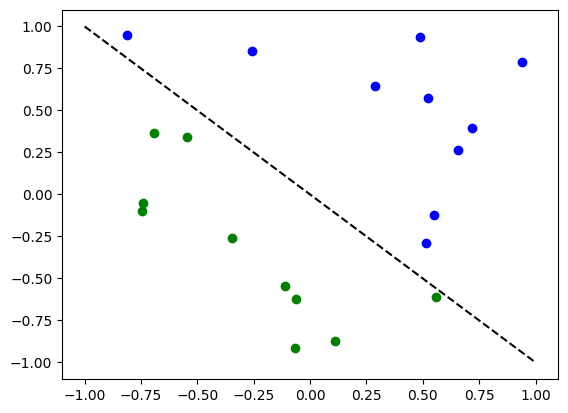

In [16]:
num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1 # Generate random data - points on a grid
y01 = 1 * (np.sum(X, axis=1) >= 0) # Generate labels - separate points on y = -x
y = 2 * y01 - 1 # Map labels to {-1, 1}
y_one_hot = np.zeros((num_samples, 2)) # Turn labels (0 or 1) into vectors 0 -> [1, 0] and 1 -> [0, 1]
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()
# Points above the line are labeled 1, points below the line are labeled -1

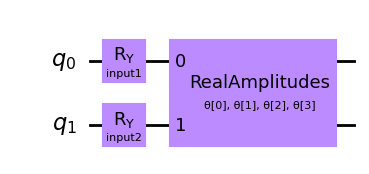

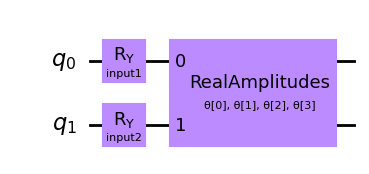

In [17]:
qc=QuantumCircuit(2)
params = [Parameter("input1"),Parameter("input2")]
qc.ry(params[0],0) # Rotate 0 qubit to set initial state
qc.ry(params[1],1) # Rotate 1 qubit to set initial state

# Create QNNCircuit with custom feature map and default RealAmplitudes ansatz
qc = QNNCircuit(
    num_qubits=2,
    feature_map=qc,  # First part (feature map, embedding) of the circuit
    ansatz=RealAmplitudes(2, reps=1) # Second part (ansatz, manipulation) of the circuit
)

qc.draw("mpl", style="clifford")

In [18]:
# Each point has two bits, [x1, x2], and a corresponding label y.
# We encode the points using angle embedding, manipulate the state in quantum space, and measure the state in Z.
# Blue points (1) should be mapped to |0> and green points (-1) should be mapped to |1>.

# Note -- try different feature map and ansatz.
# Why are they using ZZFeatureMap if all this data is independent?
# Note -- learn RealAmplitudes ansatz, NeuralNetworkClassifier, callback function, and cross-entropy loss function

estimator = Estimator()
estimator_qnn = EstimatorQNN(circuit=qc, estimator=estimator)

# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60)
)

# fit classifier to data
estimator_classifier.fit(X, y)

# score classifier
estimator_classifier.score(X, y)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


0.8

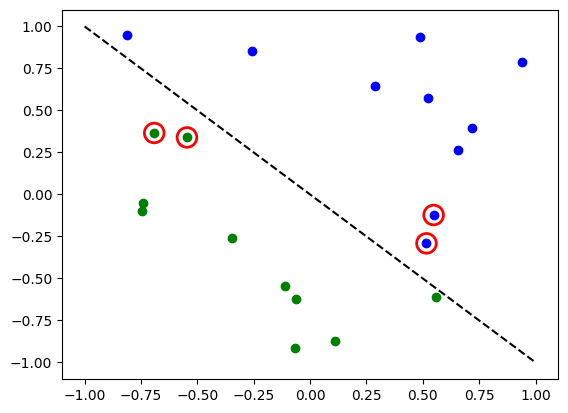

In [19]:
# evaluate data points
y_predict = estimator_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

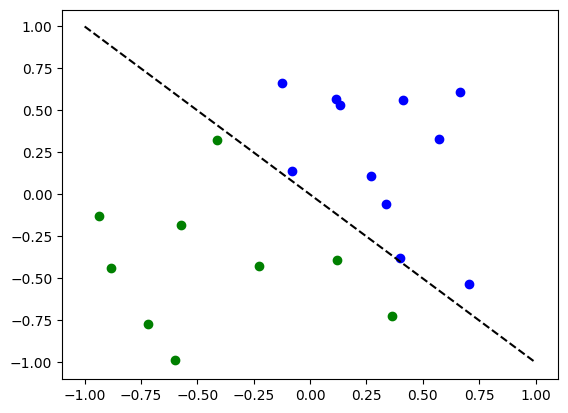

In [20]:
# Generate test data
X_test = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1 # Generate random data - points on a grid
y01_test = 1 * (np.sum(X_test, axis=1) >= 0) # Generate labels - separate points on y = -x
y_test = 2 * y01_test - 1 # Map labels to {-1, 1}
y_one_hot_test = np.zeros((num_samples, 2)) # Turn labels (0 or 1) into vectors 0 -> [1, 0] and 1 -> [0, 1]
for i in range(num_samples):
    y_one_hot[i, y01_test[i]] = 1

for x, y_target in zip(X_test, y_test):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

0.7


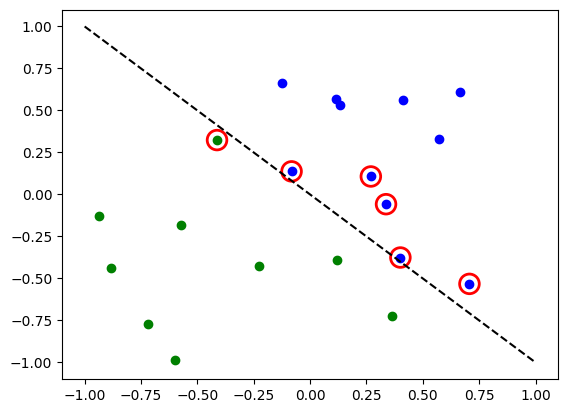

In [21]:
# Test and plot results
print(estimator_classifier.score(X_test, y_test))
# evaluate data points
y_predict = estimator_classifier.predict(X_test)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X_test, y_test, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()